# Importing library

In [43]:
import os
import torch
from PIL import Image
import opendatasets as od
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image

# Data Setting

In [44]:
batch_size = 100

## Monet dataset

In [45]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming RGB images
])

In [46]:
monet_dataset_folderurl=r'gan-getting-started\monet_jpg'

In [47]:
monet_tensor = []


for file in os.listdir(monet_dataset_folderurl):
    image_path = os.path.join(monet_dataset_folderurl, file)
    image = Image.open(image_path)
    image = transform(image)
    monet_tensor.append(image)

In [48]:
Monet_dl=DataLoader(monet_tensor, batch_size, shuffle=True, num_workers=2, pin_memory=False )

## Photos Dataset

In [49]:
photo_dataset_folderurl=r'gan-getting-started\photo_jpg'

In [50]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming RGB images
])

In [51]:
photos_tensor=[]

for file in os.listdir(photo_dataset_folderurl):
    image_path = os.path.join(photo_dataset_folderurl, file)
    image = Image.open(image_path)
    image = transform(image)  # Assuming transform is a torchvision transform
    photos_tensor.append(image)

In [52]:
photos_dl=DataLoader(photos_tensor, batch_size, shuffle=True, num_workers=2, pin_memory=False )

In [53]:
print(len(photos_tensor), len(monet_tensor))

7038 300


# Model

In [54]:
from resedual import block

## Style transfer model

In [55]:
class StyleTransfer(nn.Module):
    def __init__(self):
        super(StyleTransfer, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # shape: (batch_size, 32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # shape: (batch_size, 64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # shape: (batch_size, 128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # shape: (batch_size, 64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # shape: (batch_size, 32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # shape: (batch_size, 3, 256, 256)
            nn.Sigmoid()  # Using Sigmoid to get the output in the range [0, 1]
        )
        self.block = block(256)
    def forward(self, x):
        x = self.encoder(x)
        x= self.block(x)
        x = self.decoder(x)
        
        
        return x

In [56]:
model = StyleTransfer()

## Discriminator 

In [57]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 32, 128, 128)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 64, 64, 64)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 32, 32, 32)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 16, 16, 16)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(16, 8, kernel_size=4, stride=2, padding=2),   # shape: (batch_size, 8, 8, 8)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(8, 4, kernel_size=4, stride=2, padding=2),    # shape: (batch_size, 4, 4, 4)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(4, 2, kernel_size=4, stride=2, padding=2),    # shape: (batch_size, 2, 2, 2)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(2, 1, kernel_size=4, stride=2, padding=2),    # shape: (batch_size, 1, 1, 1)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(1, 1, kernel_size=2, stride=1, padding=0),    # shape: (batch_size, 1, 1, 1)
    nn.Flatten(),
    nn.Sigmoid()
)


In [58]:
x =discriminator(monet_tensor[0].unsqueeze(0))

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
model = model.to(device)
discriminator = discriminator.to(device)

# save_progress

In [61]:
k=0
def save_progress(k, model,  device, save=False):
    # Select the 4th image from the photos_tensor and convert it to a numpy array
  
    image_np = photos_tensor[3].cpu().detach().numpy().transpose(1, 2, 0)
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    image_np = (image_np * std) + mean
    
    # Convert numpy array back to a tensor and move it to the specified device
    image_tensor = torch.from_numpy(image_np).to(device)

    # Get the model's output for the 4th image
    #model_output_image = model(photos_tensor[3].unsqueeze(0).to(device)).cpu().detach().numpy().transpose(0, 2, 3, 1).squeeze(0)
    model_output_image = model(photos_tensor[3].unsqueeze(0).to(device)).cpu().detach().numpy().transpose(0, 2, 3, 1).squeeze(0)
    
    #model_output_image = (model_output_image * std) + mean

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the original image
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Plot the model output image
    axs[1].imshow(model_output_image)
    axs[1].set_title('Model Output')
    axs[1].axis('off')

    # Adjust the layout to make room for titles
    plt.tight_layout()

    # Save the figure if needed
    if save:
        fig.savefig(r'Output\output_images_{i}.png'.format(i=k))
        #output_path = os.path.join(r'output2', 'output_images_{i}.png'.format(i=k))
        #plt.imsave(output_path, model_output_image)
        model_output_pil = Image.fromarray((model_output_image * 255).astype(np.uint8))

        # Resize the image to 2x zoom
        width, height = model_output_pil.size
        new_size = (width * 4, height * 4)
        resized_image = model_output_pil.resize(new_size, )#Image.ANTIALIAS)

        # Save the resized image
        output_path = os.path.join(r'output2', 'output_images_{i}.png'.format(i=k))
        resized_image.save(output_path)

        # Close the plot to free up memory
        plt.close(fig)

    
    return k

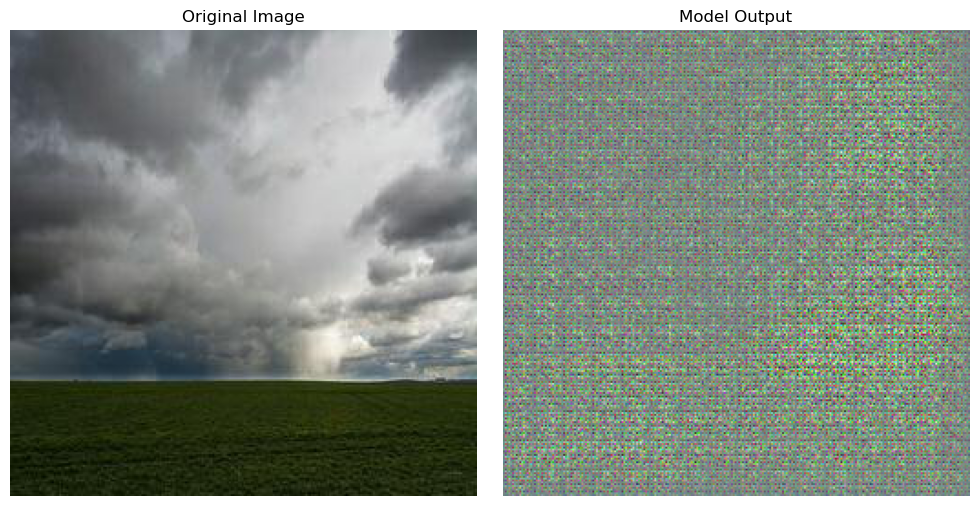

In [62]:
k= save_progress(k+1,model, device, save= False )

# Train discriminator

In [63]:
import torch.nn.functional as F

In [64]:
class_weights = torch.tensor([1.0, 23.33])  # Adjust the weights accordingly


In [65]:
def train_discriminator(real_images, fake_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Forward pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1,  device=device )
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    

    style_trans_img = model(fake_images)
    style_trans_img_pred = discriminator(style_trans_img)
    style_trans_img_targets = torch.zeros(fake_images.size(0), 1,  device=device )

    
    #style_trans_img_targets = torch.zeros(fake_images.size(0), 1,  device=device )
    trans_loss = F.binary_cross_entropy(style_trans_img_pred, style_trans_img_targets)
     

    # Forward pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  

    # Combine losses and backpropagate
    loss_d =   trans_loss + fake_loss + real_loss 
    loss_d.backward()
    opt_d.step()


    return loss_d.item(), real_preds.mean().item(), fake_preds.mean().item()
    

# Train generator

In [66]:
def train_generator( opt_g, fake_images, real_images):
    opt_g.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_preds = real_preds.to(device)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    #generated image                                                                    #for real_images , fake_images in tqdm(zip(Monet_dl, photos_dl)):
    generated_images = model(fake_images)
    generated_images=generated_images.to(device)
    preds = discriminator(generated_images)
    preds= preds.to(device)
    targets = torch.zeros(batch_size, 1, device=device)  #chnged from ones to zeros
    #loss_g = torch.nn.BCELoss()(preds, targets)
    loss_g = F.binary_cross_entropy(preds, targets)

    loss_g.backward()
    opt_g.step()
    
    return loss_g.item()

# Loading model

In [67]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
discriminator.to(device)

# Load the state dictionaries
try:
 model.load_state_dict(torch.load('model_output/model.pth', map_location=device))
 discriminator.load_state_dict(torch.load('model_output/discriminator.pth', map_location=device))
except:
 print("model not found")

# Set the model and discriminator to evaluation mode if needed
model.eval()
discriminator.eval()


Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (9): LeakyReLU(negative_slope=0.2, inplace=True)
  (10): Conv2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (13): LeakyReLU(negative_slope=0.2, inplace=True)
  (14): Conv2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (15): LeakyReLU(negative_slope=0.2, inplace=True

# Training model

In [68]:
import os, re
def get_k():
 try:
  files = sorted(os.listdir(r'Output'))
  numbers = [int(re.search(r'\d+', filename).group()) for filename in files]
  k = max(numbers)
 except:
  k = 0
 return k

In [ ]:
def fit(epochs,lr_g, lr_d):
    torch.cuda.empty_cache()
    k = get_k()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(model.parameters(), lr=lr_g, betas=(0.5, 0.999))
#    opt_g = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs)):
        #for real_images , fake_images in tqdm(zip(Monet_dl, photos_dl)):
        for real_images , fake_images in zip(Monet_dl, photos_dl):
            real_images = real_images.to(device)
            fake_images = fake_images.to(device)
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, fake_images,opt_d)

            loss_g  = train_generator( opt_g, fake_images, real_images)#, device)
     
                        
        # Record losses & scores
        
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        if epoch % 10 == 0:
         mean_real_score = np.mean(real_scores)
         mean_fake_score = np.mean(fake_scores)
         print(f"Epoch [{epoch}/{epochs}],k: {k}, loss_g: {loss_g:.6f}, loss_d: {loss_d:.6f}, real_score: {mean_real_score:.6f}, fake_score: {mean_fake_score:.6f}")

         # Save generated images
         k= save_progress(k+1,model,device,  save= True )


    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr_d = 0.002
lr_g =0.02
epochs =300

In [ ]:
%%time
history = fit(500,lr_g, lr_d)

In [70]:
lr_d = 0.0002
lr_g =0.0005
epochs =300

In [71]:
%%time
history = fit(epochs,lr_g, lr_d)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300],k: 318, loss_g: 3.859526, loss_d: 0.682359, real_score: 0.771692, fake_score: 0.192295
Epoch [5/300],k: 319, loss_g: 4.053287, loss_d: 0.839680, real_score: 0.723689, fake_score: 0.179490
Epoch [10/300],k: 320, loss_g: 3.887340, loss_d: 1.059138, real_score: 0.742472, fake_score: 0.192389
Epoch [15/300],k: 321, loss_g: 3.916991, loss_d: 0.792750, real_score: 0.748135, fake_score: 0.193347
Epoch [20/300],k: 322, loss_g: 4.361477, loss_d: 0.686297, real_score: 0.757238, fake_score: 0.194503
Epoch [25/300],k: 323, loss_g: 3.840882, loss_d: 0.658000, real_score: 0.755874, fake_score: 0.197223
Epoch [30/300],k: 324, loss_g: 3.461196, loss_d: 0.820672, real_score: 0.761009, fake_score: 0.201736
Epoch [35/300],k: 325, loss_g: 3.815014, loss_d: 0.626670, real_score: 0.765272, fake_score: 0.205099
Epoch [40/300],k: 326, loss_g: 3.977692, loss_d: 0.728305, real_score: 0.767244, fake_score: 0.207745
Epoch [45/300],k: 327, loss_g: 4.117953, loss_d: 0.808519, real_score: 0.766453, fak

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [0/500],k: 386, loss_g: 8.667769, loss_d: 9.593212, real_score: 0.120311, fake_score: 0.002076
Epoch [5/500],k: 387, loss_g: 7.660475, loss_d: 0.839257, real_score: 0.534085, fake_score: 0.198227


KeyboardInterrupt: 

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

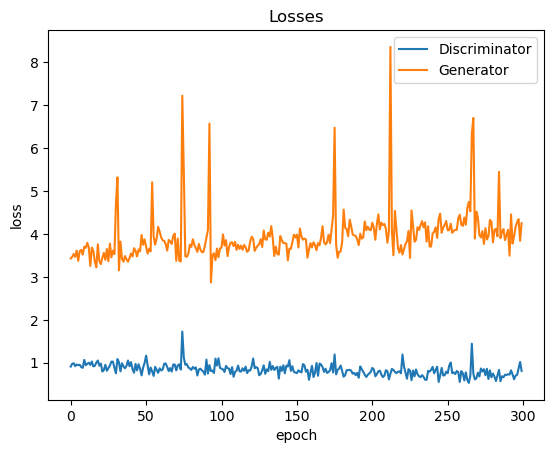

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

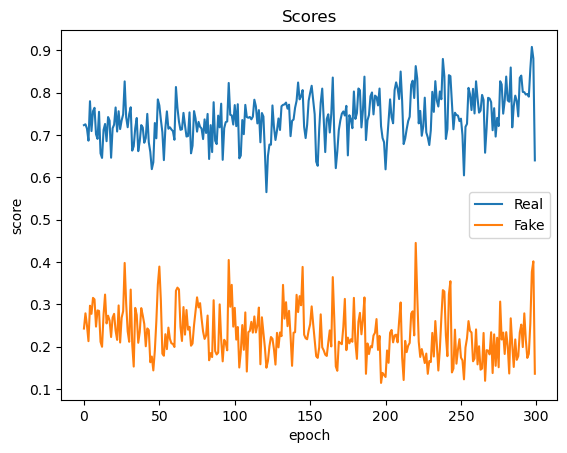

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Save Model

In [ ]:
torch.save(model.state_dict(), 'model_output/model.pth')
torch.save(discriminator.state_dict(), 'model_output/discriminator.pth')